## Import libraries and datasets

In [405]:
%matplotlib inline
import matplotlib.pyplot as plt  # Data visualization
import seaborn as sns # Data visualization
import numpy as np   #fundamental package for scientific computing
import pandas as pd  #fundamental package for data analysis

from sklearn.ensemble import RandomForestClassifier # package for binary classification (decision tree)
from sklearn.ensemble import GradientBoostingClassifier # package for binary classification (decision tree)
from sklearn.linear_model import LogisticRegression # package for binary classification (logistic regression)
from sklearn import metrics # package for getting metrics out of the model
from sklearn.metrics import confusion_matrix # package for getting metrics out of the model
from sklearn.metrics import f1_score # package for getting metrics out of the model
from sklearn.metrics import roc_auc_score, roc_curve, auc # Metrics for classification algorithms
from sklearn.model_selection import train_test_split # package to split the data in a training and crossvalidation set
from sklearn.model_selection import GridSearchCV # package to search and find the best hyperparameters on the model
from sklearn.preprocessing import StandardScaler # package to scale (normalize) the features
from sklearn.preprocessing import PolynomialFeatures # package to add features interactions
from sklearn.pipeline import Pipeline # package to create a pipeline for the machine learning model


In [406]:
# Load the different data sources

zip_code = pd.read_csv('zip_metric.csv')

# Customers
df_cust_data = pd.read_excel('mazda_dataset.xlsx','Customer data')
df_campaign_customers = pd.read_excel('mazda_dataset.xlsx','Campaigns_customers')
df_chimp_glob_customers = pd.read_csv('chimp_global_cust')
df_chimp_tags_customers = pd.read_csv('tags_cust_proc')

# Prospects
df_prospects_data = pd.read_excel('mazda_dataset.xlsx','Prospects data')
df_campaign_prospects = pd.read_excel('mazda_dataset.xlsx','Campaigns_prospects')
df_chimp_glob_prospects = pd.read_csv('chimp_global_prosp') 
df_chimp_tags_prospects = pd.read_csv('tags_prosp_proc')

## Cleaning from original Mazda dataset

In [407]:
print('prospects: ',len(df_prospects_data),'customers: ',len(df_cust_data))

prospects:  6738 customers:  1881


In [408]:
intersections = list(set(df_cust_data['Contact Row ID']).intersection(list(set(df_prospects_data['Contact Row ID']))))
print("There are ", len(intersections), " customers that are present both in the customers and prospect dataset")

There are  276  customers that are present both in the customers and prospect dataset


In [409]:
# We need to remove these rows from the prospects as these are not prospects anymore
df_prospects_data_2 = df_prospects_data[~df_prospects_data['Contact Row ID'].isin(intersections)]

In [410]:
# We need to remove all the prospects customers that are recent as we don't know if there will be customers or not
# We want to keep in the prospects only the customers that did not convert to customers.
df_prospects_data_3 = df_prospects_data_2[df_prospects_data_2['Response Date'] < '07/31/2017'] 

In [411]:
print('prospects: ',len(df_prospects_data_3),'customers: ',len(df_cust_data))

prospects:  5174 customers:  1881


In [412]:
# We need to remove the duplicates users in the customer data set as they refer to customers that have purchased
# more than one car (MX5 RF and MX-5 Roadster). We only need to keep one row per user regardless of how many cars 
# he has purchased.
df_cust_data_2 = df_cust_data.drop_duplicates(subset = 'Contact Row ID')

# code to check the duplicates:
# test = df_cust_data.groupby('Contact Row ID').count()['Last Name']
# df_cust_data[df_cust_data['Contact Row ID'].isin(test[test > 1].index)].sort_values('Contact Row ID')

In [413]:
print('prospects: ',len(df_prospects_data_3),'customers: ',len(df_cust_data_2))

prospects:  5174 customers:  1869


In [414]:
# We need to remove the duplicates from the prospects as they refer to customers that have different
# Opportunity_type_I (have made multiple requests). As we don't have this count in the customer dataset, we cannot 
# use it.
df_prospects_data_4 = df_prospects_data_3.drop_duplicates(subset = 'Contact Row ID')

In [415]:
print('prospects: ',len(df_prospects_data_4),'customers: ',len(df_cust_data_2))

prospects:  4482 customers:  1869


In [416]:
# We need to remove records that are not from Belgium. This POC will focus on Belgian users.
df_cust_data_3 = df_cust_data_2[df_cust_data_2['Country_I'] == 'Belgium']
df_prospects_data_5 = df_prospects_data_4[df_prospects_data_4['Country_I'] == 'Belgium']

In [417]:
print('prospects: ',len(df_prospects_data_5),'customers: ',len(df_cust_data_3))

prospects:  3985 customers:  1690


In [418]:
# Finally, we need to remove from both datasets users that did not provide an email address as they will lack a lot
# of data from mailchimp. This is fine as only a few records don't have an email address.
df_cust_data_3 = df_cust_data_3[df_cust_data_3['Email Address'].notnull()]
df_prospects_data_5 = df_prospects_data_5[df_prospects_data_5['Email Address'].notnull()]

In [419]:
print('prospects: ',len(df_prospects_data_5),'customers: ',len(df_cust_data_3))

prospects:  3593 customers:  1522


In [420]:
df_cust_data_3.columns

Index(['Contact Row ID', 'Preferred Language', 'Personal Title_I',
       'First Name', 'Last Name', 'Street Address', 'Street Address 2', 'City',
       'Postal Code', 'Country_I', 'Email Address', 'Business Phone #',
       'Private Phone #', 'Cell Phone #', 'Explicit Mail Permission_I',
       'Explicit Email Permission_I', 'Explicit Call Permission_I',
       'Explicit SMS Permission_I', 'Birthday', 'Model_I', 'VIN',
       'Registration Date', 'Model Number', 'Sales Dealer #',
       'Sales Dealer Name', 'Sales Dealer Country_I',
       'Contact Service Dealer #', 'Contact Service Dealer Name',
       'Contact Service Dealer Country_I', 'Service Date', 'Current Mileage',
       'Own(ed) a Mazda', 'Model', 'MX-5 Lead', 'MOI', 'Date'],
      dtype='object')

In [421]:
df_prospects_data_5.columns

Index(['Contact Row ID', 'First Name', 'Last Name', 'Street Address',
       'Street Address 2', 'Street Address 3', 'Postal Code', 'City',
       'Country_I', 'Email Address', 'Business Phone #', 'Private Phone #',
       'Cell Phone #', 'Explicit Mail Permission_I',
       'Explicit Email Permission_I', 'Explicit Call Permission_I',
       'Explicit SMS Permission_I', 'Model of Interest', 'Response Date',
       'Opportunity Type_I', 'Own(ed) a Mazda', 'Model'],
      dtype='object')

**Columns to keep from original data set:**
- Preferred Language
- Personal Title
- Postal code
- Email address
- Business Phone
- Private Phone
- Cell Phone
- Explicit Mail Permission
- Explicit Email Permission
- Explicit Call Permission
- Explicit SMS Permission
- Owned a mazda
- MX5 Lead in cust dataset - Opportunity Type I in prosp dataset

In [422]:
# As we will get the gender in different ways from the customer and prospect table, we need to feature engineer 
# this before concatenating the tables

In [423]:
# For the customer dataset, we will deduct the gender from the "Personal_Title" column
df_cust_data_3.loc[:,'Gender'] = df_cust_data_2['Personal Title_I']\
                            .apply(lambda x: "F" if ((x == "Miss") | (x == 'Mrs') | (x == 'Ms')) else "M")

In [424]:
# For the prospect dataset, we will deduct the gender from the "First name" column using a gender guesser library
import gender_guesser.detector as gender
d = gender.Detector()
print(d.get_gender(u"Bob"))
df_prospects_data_5.loc[:,'Gender'] = df_prospects_data_5['First Name']\
                                        .apply(lambda x: d.get_gender(x))
df_prospects_data_5.replace(to_replace = \
                                {'Gender': {'male': 'M', 'unknown': 'M', 'female': 'F', 'mostly_male': 'M',\
                                    'andy': 'M', 'mostly_female': 'F', 'andy': 'M', 'mostly_female': 'F'}},\
                           inplace = True)

male


In [425]:
# For the prospect dataset, we miss the language and we will infer this language from the postal code. For consumer
# with no postal code, we remove them from the dataset as it was a limited amount
df_prospects_data_6 = df_prospects_data_5[df_prospects_data_5['Postal Code'] != 'Unspecified']
df_prospects_data_6['Postal Code2'] = df_prospects_data_6['Postal Code'].apply(lambda x: x[2:] if x[0] == 'L' else x[:4])
df_prospects_data_6['Postal Code2'] = df_prospects_data_6['Postal Code2'].apply(lambda x: x if x.isnumeric() else 'Unspecified')
df_prospects_data_6['Postal Code'] = df_prospects_data_6['Postal Code2'].astype('int64')

df_cust_data_3['Postal Code2'] = df_cust_data_3['Postal Code'].apply(lambda x: x[2:] if x[0] == 'L' else x[:4])
df_cust_data_3['Postal Code2'] = df_cust_data_3['Postal Code2'].apply(lambda x: x if x.isnumeric() else 'Unspecified')
df_cust_data_3['Postal Code'] = df_cust_data_3['Postal Code2'].astype('int64')
df_cust_data_3.drop(['Postal Code2'], axis = 1, inplace = True)

/home/charly/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/charly/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/charly/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [426]:
# merge the zip code with prospect dataset to get the language
zip_lang = zip_code[['province', 'postal_code']]
df_prospects_data_7 = df_prospects_data_6.merge(zip_lang, how = 'left',\
                                         left_on = 'Postal Code', right_on = 'postal_code')
df_prospects_data_7['Preferred Language'] = df_prospects_data_7['province']\
                    .apply(lambda x: 'FRA' if ((x == 'WAL')|(x == 'BXL')) else 'NLD')
df_prospects_data_7.drop(['Postal Code2','postal_code', 'province'], axis = 1, inplace = True)

In [427]:
# Keep only relevant columns for predictions
df_cust_data_final = df_cust_data_3[['Preferred Language', 'Gender','Postal Code',\
                                     'Email Address','Business Phone #','Private Phone #', 'Cell Phone #',\
                                     'Explicit Mail Permission_I','Explicit Email Permission_I',\
                                     'Explicit Call Permission_I','Explicit SMS Permission_I', 'Own(ed) a Mazda',
                                     'MX-5 Lead'\
                                    ]].rename(index = str, columns={"MX-5 Lead": "Channel"})
df_cust_data_final['Customer'] = 1

df_prosp_data_final = df_prospects_data_7[['Preferred Language','Gender','Postal Code',\
                                     'Email Address','Business Phone #','Private Phone #', 'Cell Phone #',\
                                     'Explicit Mail Permission_I','Explicit Email Permission_I',\
                                     'Explicit Call Permission_I','Explicit SMS Permission_I', 'Own(ed) a Mazda',\
                                     'Opportunity Type_I'
                                    ]].rename(index = str, columns={"Opportunity Type_I": "Channel"})
df_prosp_data_final['Customer'] = 0

In [464]:
df_cust_prosp = pd.concat([df_cust_data_final, df_prosp_data_final], ignore_index = True)

In [465]:
df_cust_prosp

,Preferred Language,Gender,Postal Code,Email Address,Business Phone #,Private Phone #,Cell Phone #,Explicit Mail Permission_I,Explicit Email Permission_I,Explicit Call Permission_I,Explicit SMS Permission_I,Own(ed) a Mazda,Channel,Customer
0,FRA,M,3404,alain.v@live.be,NaN,+32474753767,3.247475e+10,Permit,Permit,Permit,Permit,N,Brochure request,1
1,NLD,M,9111,cop12@skynet.be,NaN,NaN,3.247175e+10,Permit,Permit,Permit,Permit,N,NaN,1
2,NLD,M,9170,vrijbuiter@telenet.be,NaN,NaN,4.956099e+08,Permit,Permit,Permit,Permit,N,NaN,1
3,FRA,M,4121,syl_de@hotmail.com,NaN,NaN,3.249649e+10,Permit,Permit,Permit,Permit,N,NaN,1
4,FRA,M,4300,danielledouha@gmail.com,NaN,NaN,3.204760e+11,Permit,Permit,Permit,Permit,N,Brochure request,1
5,NLD,M,9800,chris.de.waele1@telenet.be,NaN,NaN,3.247402e+10,Permit,Permit,Permit,Permit,N,NaN,1
6,NLD,M,3910,l.schouteten@outlook.com,NaN,+3211822430,3.248643e+10,Permit,Permit,Permit,Permit,N,Test Drive request,1
7,FRA,M,6762,ericvanbrackel@outlook.be,NaN,NaN,3.204708e+11,Permit,Permit,Permit,Permit,Y,NaN,1
8,FRA,M,1090,fdutron@skynet.be,NaN,NaN,3.204755e+11,Permit,Permit,Permit,Permit,N,NaN,1
9,NLD,M,2900,andres.abdq@outlook.com,NaN,NaN,3.249283e+10,Permit,Permit,Permit,Permit,N,NaN,1


## Feature Engineering

Columns to engineer from original dataset
- Postal code into categories
- Email address:
    - Private
    - Business
    - No email
- Business Phone: one hot encoding if empty or not
- Business Phone: one hot encoding if empty or not
- Private Phone: one hot encoding if empty or not
- Cell Phone: one hot encoding if empty or not
- Explicit Mail Permission: one hot encoding if empty or not
- Explicit Email Permission: one hot encoding if empty or not
- Explicit Call Permission: one hot encoding if empty or not
- Explicit SMS Permission: one hot encoding if empty or not
- Owned a mazda: one hot encoding if empty or not

In [466]:
def domainsplit(x):
    try:
        return x.split('@')[1].split('.')[0].lower()
    except:
        return None

In [467]:
def business_email(x):
    if x is None:
        return None
    elif x in ['skynet', 'telenet', 'hotmail', 'msn', 'voo', 'gmail', 'yahoo', 'gamail', 'msn', 'ymail']:
        return "Private Email"
    else:
        return "Business Email"

In [468]:
df_cust_prosp['type_email'] = df_cust_prosp['Email Address'].apply(lambda x: domainsplit(x))\
                              .apply(lambda x: business_email(x))

In [469]:
df_cust_prosp.columns

Index(['Preferred Language', 'Gender', 'Postal Code', 'Email Address',
       'Business Phone #', 'Private Phone #', 'Cell Phone #',
       'Explicit Mail Permission_I', 'Explicit Email Permission_I',
       'Explicit Call Permission_I', 'Explicit SMS Permission_I',
       'Own(ed) a Mazda', 'Channel', 'Customer', 'type_email'],
      dtype='object')

In [470]:
# One-hot encode the different columns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_cust_prosp['Preferred Language'] = le.fit_transform(df_cust_prosp['Preferred Language'])
df_cust_prosp['Gender'] = le.fit_transform(df_cust_prosp['Gender'])
df_cust_prosp['Business Phone #'] = np.where(df_cust_prosp['Business Phone #'].isnull(),0,1)
df_cust_prosp['Private Phone #'] = np.where(df_cust_prosp['Private Phone #'].isnull(),0,1)
df_cust_prosp['Cell Phone #'] = np.where(df_cust_prosp['Cell Phone #'].isnull(),0,1)
df_cust_prosp['Explicit Mail Permission_I'] = le.fit_transform(df_cust_prosp['Explicit Mail Permission_I'])
df_cust_prosp['Explicit Email Permission_I'] = le.fit_transform(df_cust_prosp['Explicit Email Permission_I'])
df_cust_prosp['Explicit Call Permission_I'] = le.fit_transform(df_cust_prosp['Explicit Call Permission_I'])
df_cust_prosp['Explicit SMS Permission_I'] = le.fit_transform(df_cust_prosp['Explicit SMS Permission_I'])
df_cust_prosp['Own(ed) a Mazda'] = le.fit_transform(df_cust_prosp['Own(ed) a Mazda'])
df_cust_prosp['type_email'] = le.fit_transform(df_cust_prosp['type_email'])

**Columns engineered imported from MailChimp:**
- Total Email received
- Total emails opened at least once
- Total number of times a user opened an email from any Mazda campaign
- Total number of emails not opened
- Total number of emails reported as abuse
- Total number of times a user click in an email from any Mazda campaign
- Total number of emails bounced 
- Total number of emails unsub
- Chimp member rating

In [471]:
# For machine learning purpose, we cannot have missing values.
Columns_to_fill_with_O = ['Chimp_Total_Emails','Chimp_opened_once', 'Chimp_opened_multi', 'Chimp_not_opened',\
          'Chimp_abuse','Chimp_clicks','Chimp_bounces', 'Chimp_unsub']

# Customers
df_chimp_glob_customers[Columns_to_fill_with_O] = df_chimp_glob_customers[Columns_to_fill_with_O].fillna(0)
df_chimp_glob_customers['Chimp_member_rating'].fillna(2, inplace= True)

df_chimp_glob_customers = df_chimp_glob_customers[['Email Address','Chimp_Total_Emails','Chimp_opened_once', 'Chimp_opened_multi', 'Chimp_not_opened',\
          'Chimp_abuse','Chimp_clicks','Chimp_bounces', 'Chimp_unsub', 'Chimp_member_rating']]

# Prospects
df_chimp_glob_prospects[Columns_to_fill_with_O] = df_chimp_glob_prospects[Columns_to_fill_with_O].fillna(0)
df_chimp_glob_prospects['Chimp_member_rating'].fillna(2, inplace= True)

df_chimp_glob_prospects = df_chimp_glob_prospects[['Email Address','Chimp_Total_Emails','Chimp_opened_once', 'Chimp_opened_multi', 'Chimp_not_opened',\
          'Chimp_abuse','Chimp_clicks','Chimp_bounces', 'Chimp_unsub', 'Chimp_member_rating']]

df_chimp_glob = pd.concat([df_chimp_glob_customers, df_chimp_glob_prospects])
df_chimp_glob = df_chimp_glob.drop_duplicates(subset = 'Email Address')
df_chimp_glob.drop(df_chimp_glob[df_chimp_glob['Email Address'] == 'no email'].index, inplace = True)

In [472]:
# Merge the global chimp data to main the dataframe
df_cust_prosp = df_cust_prosp.merge(df_chimp_glob, left_on = 'Email Address',\
                right_on = 'Email Address', how = 'left')
df_cust_prosp[Columns_to_fill_with_O] = df_cust_prosp[Columns_to_fill_with_O].fillna(0)
df_cust_prosp['Chimp_member_rating'].fillna(2, inplace= True)

We then also get 85 columns engineered from manual tags from the different campaigns. Each campaign is labelled with a tag and for each user we calculate how many times he received this tag. The formula in itself is:
- number of time he opens a campaign with this tag + 2 * number of time he clicks a campaign with this tag

In [473]:
df_chimp_tags = pd.concat([df_chimp_tags_customers, df_chimp_tags_prospects])
df_chimp_tags = df_chimp_tags.drop_duplicates(subset = 'Email Address')
df_chimp_tags.drop(df_chimp_tags[df_chimp_tags['Email Address'] == 'no email'].index, inplace = True)

In [474]:
# Merge the chimp tags data to the main dataframe
df_cust_prosp = df_cust_prosp.merge(df_chimp_tags, left_on = 'Email Address',\
                right_on = 'Email Address', how = 'left')
df_cust_prosp[df_chimp_tags.columns[1:].tolist()] = df_cust_prosp[df_chimp_tags.columns[1:].tolist()].fillna(0)

**Columns imported from Public data:**

All these columns are average socio-economic features per zip code. It means these are aggregates and should be used with care. We will run our machine learning model with and without these columns to see how it evolves.

In [476]:
zip_code = zip_code[['postal_code','age_lt18_pt', 'age_18-65_pt', 'age_gt65_pt',
       'age_avg', 'single_pt', 'maried_pt', 'widow_pt', 'divorced_pt',
       'belgian_pt', 'alien_pt', 'residential_pt', 'industry_pt',
       'exploitation_pt', 'commercial_pt', 'public_pt', 'mixte_pt',
       'transport_pt', 'infra_pt', 'leasure_pt', 'salaried_pt',
       'working_outside_pt', 'superior_degree_pt', 'independant_pt',
       'idleness_pt', 'pop_density', 'family_size', 'owner_renter_pt',
       'avg_wage']]

In [477]:
# Merge the chimp tags data to the main dataframe
df_cust_prosp = df_cust_prosp.merge(zip_code, left_on = 'Postal Code',\
                right_on = 'postal_code', how = 'left')

df_cust_prosp.drop(df_cust_prosp[df_cust_prosp['leasure_pt'].isnull()].index, inplace = True)

## Visualizations

Based on the consolidated dataset, we will now draw some visualizations that will already give us some insights on what features discrimante well between my users and prospecters.

In [540]:
# We check for the conversion probability for some features
colors = ['#59a862','#ff7f66']

# Private Phone conversion probability
    
P_phone = pd.crosstab(df_cust_prosp['brake_and_drifting_course'],df_cust_prosp['Customer'])

In [541]:
P_phone

Customer,0,1
brake_and_drifting_course,,
0.0,3441,1057
1.0,104,377
2.0,9,79


## Machine Learning

### Random Forest

For the machine elarning, we now have to remove the columns that were used for the joins. These columns were:

- Email Address
- Postal Code

We will drop the channel column as there are too many missing values for the customers and the model will then simply learn on this fact

In [534]:
df_cust_prosp_ML = df_cust_prosp.drop(['Postal Code', 'Email Address',\
                                       'Channel', 'Private Phone #', 'Cell Phone #',\
                                       'Explicit Call Permission_I', 'Explicit Mail Permission_I',\
                                       'Explicit SMS Permission_I', 'Explicit Email Permission_I',\
                                       'winter_wheels'], axis = 1)\
                    .reset_index().drop('index', axis = 1)

In [535]:
# We know have isolate the learning features from the target features
X_ML = df_cust_prosp_ML.loc[:, df_cust_prosp_ML.columns != 'Customer']
Y_ML = df_cust_prosp_ML['Customer']
print(' shape of X: ', X_ML.shape,"\n",'shape of Y: ', Y_ML.shape)

 shape of X:  (5067, 127) 
 shape of Y:  (5067,)


In [536]:
# sanity check to be sure the dataframe does not contain any missing values
X_ML.columns[X_ML.isnull().any()].tolist()

[]

In [537]:
# Let's now split the dataset randomly into a training set and a test set
x_train, x_val, y_train, y_val = train_test_split(X_ML, Y_ML, test_size=0.33, random_state = 42)

In [538]:
clf = GradientBoostingClassifier(learning_rate = 0.03, max_depth = 5, random_state = 0).fit(x_train, y_train)

# area under the curve (AUC) score for training dataset
y_train_score = clf.predict_proba(x_train)[:,1]
roc_auc_train = roc_auc_score(y_train, y_train_score)
    
# area under the curve (AUC) score for test dataset
y_val_score = clf.predict_proba(x_val)[:,1]
roc_auc_val = roc_auc_score(y_val, y_val_score)

print('ROC for training set: ', "{0:.3f}".format(roc_auc_train))
print('ROC for the validation set: ', "{0:.3f}".format(roc_auc_val))

ROC for training set:  0.921
ROC for the validation set:  0.861


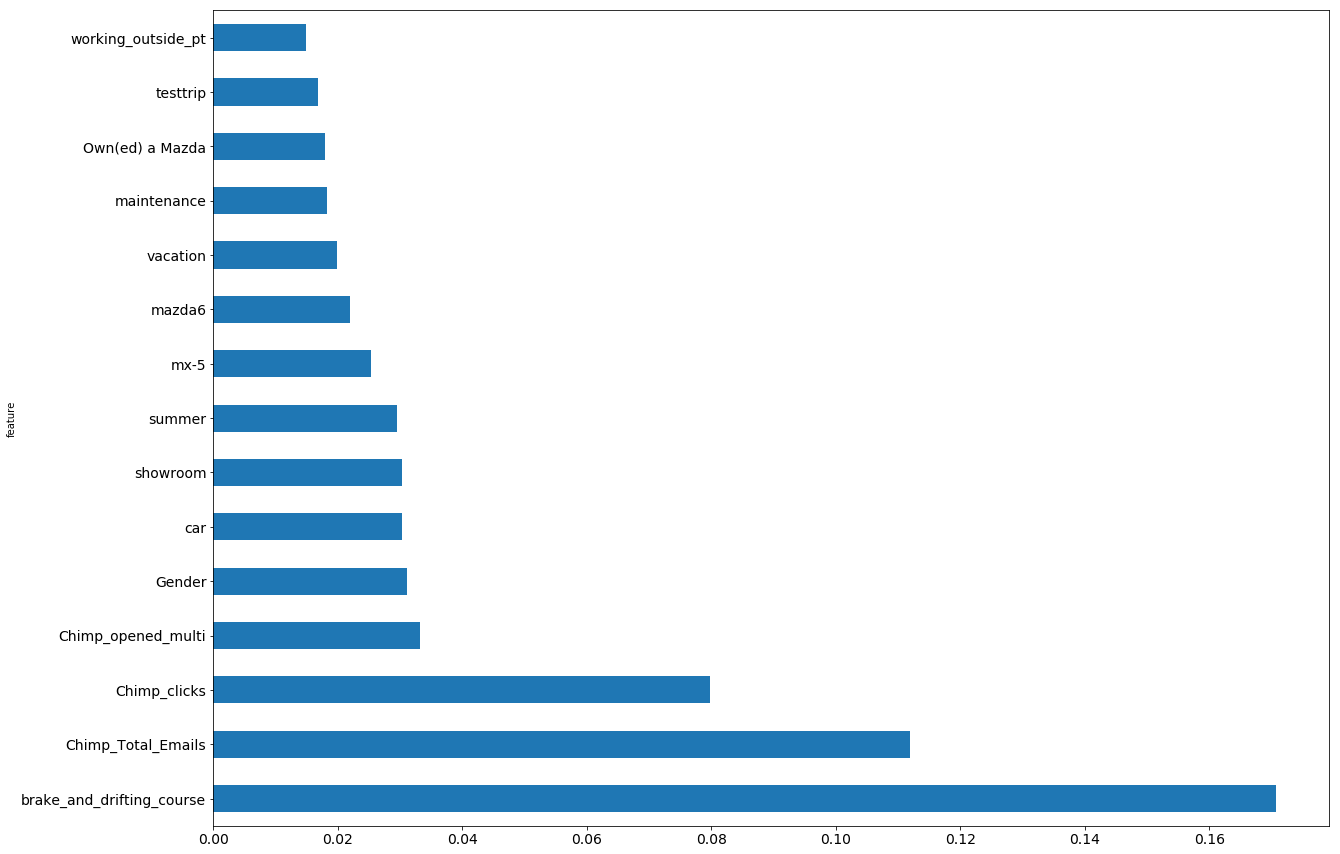

In [539]:
features = pd.DataFrame()

features['feature'] = X_ML.columns
features['importance'] = clf.feature_importances_
features.sort_values(by = ['importance'], ascending = True, inplace = True)
features.set_index('feature', inplace = True)
# plot the 'top 15' features
features[:-16:-1].plot(kind = 'barh', figsize = (20, 15), legend = None)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.show()

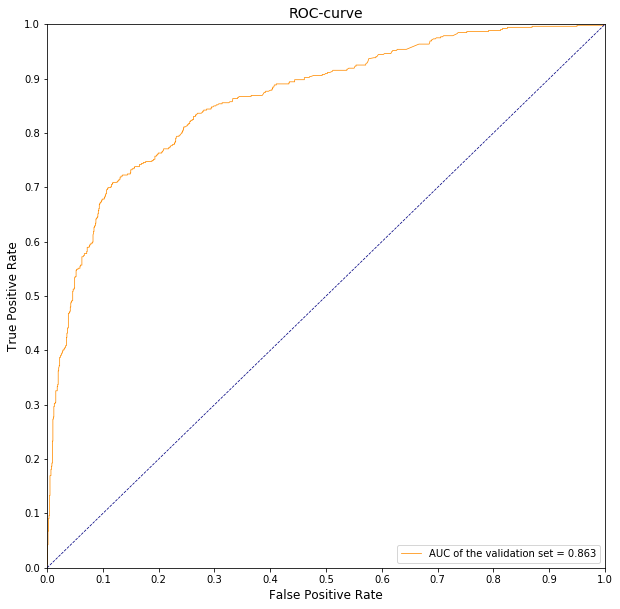

In [531]:
# plot the ROC-curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_val, y_val_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (10, 10))

ax = plt.gca()

plt.title('ROC-curve', fontsize = 14)
plt.plot(fpr, tpr, color = 'darkorange', lw = 0.75, label = 'AUC of the validation set = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], color = 'navy', lw = 0.75, linestyle = '--')

xticks_major = np.round(np.linspace(0, 1, 11), 1)
xticks_major_str = (xticks_major).astype(str).tolist()
xticks_labels = [x for x in xticks_major_str]

yticks_major = np.round(np.linspace(0, 1, 11), 1)
yticks_major_str = (yticks_major).astype(str).tolist()
yticks_labels = [x for x in yticks_major_str]

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xticks(xticks_major)
ax.set_xticklabels(xticks_labels, fontsize = 10)
ax.set_yticks(yticks_major)
ax.set_yticklabels(yticks_labels, fontsize = 10)

plt.ylabel('True Positive Rate', fontsize = 12)
plt.xlabel('False Positive Rate', fontsize = 12)
plt.show()

In [ ]:
# Random Forest

estimators = [
           # ('scale_predictors', StandardScaler()),
            ('randomforests', RandomForestClassifier())
            ]

clf = Pipeline(estimators)

grid_values = dict(randomforests__max_depth=[None], 
                   randomforests__n_estimators=[10, 100])
              
# default metric to optimize over grid parameters: accuracy
grid_clf_rf_acc = GridSearchCV(clf, param_grid = grid_values, scoring = 'roc_auc')
grid_clf_rf_acc.fit(train_x, train_y)

y_pred_rf = grid_clf_acc.predict(test_x) # array with 1 and 0 for the prediction on test_x. 

print('Grid best parameter (max. accuracy): ', grid_clf_rf_acc.best_params_)
print('Grid best score (accuracy): ', grid_clf_rf_acc.best_score_)
print('Test score (accuracy): ', (y_pred_rf == test_y).mean())

In [ ]:
# Logistic Regression model

estimators = [
            ('scale_predictors', StandardScaler()),
            #('poly features', PolynomialFeatures(interaction_only = True)),
            ('logisticregression', LogisticRegression())
            ]

clf = Pipeline(estimators)

grid_values = dict(logisticregression__C = [0.01,0.1, 1, 3], # Inverse of the regularization factor.
                   logisticregression__max_iter= [50,100,500],
                  )

# default metric to optimize over grid parameters: accuracy
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values, scoring = 'roc_auc')
grid_clf_acc.fit(train_x, train_y)

y_pred = grid_clf_acc.predict(test_x) # array with 1 and 0 for the prediction on test_x. 

print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
print('Grid best score (AUC_ROC): ', grid_clf_acc.best_score_)
print('Test score (accuracy): ', (y_pred == test_y).mean())